In [1]:
import math
import pandas as pd
import numpy as np
import scipy as sp
import sklearn as sk
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap

RATES = [1,2,3,4,5]

def loadData(nbChunks = 0):  # <= 0 to load all chunks, positive integer to load specific number of chunks
    asinToIndex = {}
    scoreMatrix = []
    booksAsin = []
    index = 0
    chunks = pd.read_json(
        '../Dataset/Books.json', lines=True, chunksize=500000,
        typ="frame", orient="records", dtype={"asin": str, "overall": int, "unixReviewTime": int}
    )
    for chunk in chunks:
        for _, item in chunk.iterrows():
            asin = item["asin"]
            rate = item["overall"]
            if (asin not in asinToIndex):
                scoreMatrix.append([0,0,0,0,0])
                booksAsin.append(asin)
                asinToIndex[asin] = index
                index += 1
            row = asinToIndex[asin]
            scoreMatrix[row][rate-1] += 1
        nbChunks -= 1
        if (nbChunks == 0): break
    scoreMatrix = np.array(scoreMatrix)
    nbNonAppreciate = scoreMatrix[:,0]+scoreMatrix[:,1]
    nbNeutral = scoreMatrix[:,2]
    nbAppreciate = scoreMatrix[:,3]+scoreMatrix[:,4]
    realClass = np.argmax(np.column_stack((nbNonAppreciate, nbNeutral, nbAppreciate)), axis=1).astype(int)
    maxStarVotes = np.argmax(scoreMatrix, axis=1).astype(int)
    categoryMatrix = np.column_stack((nbNonAppreciate, nbNeutral, nbAppreciate, maxStarVotes, realClass))
    colNames = [f"{i} ⭐" for i in RATES]
    colNames.extend(["Depreciation", "Neutral", "Appreciations", "MaxStarVotes", "Class"])
    pdBooks = pd.DataFrame(data=np.concatenate((scoreMatrix, categoryMatrix), axis=1), index=booksAsin, columns=colNames)
    return pdBooks, scoreMatrix, categoryMatrix, booksAsin, asinToIndex

pdBooks, scoreMatrix, categoryMatrix, booksAsin, asinToIndex = loadData()
display(pdBooks)

def displayDifferentClassesCount(pdBooks):
    print("Different classes count : ")
    classesCount = np.array([
        [(pdBooks.Class.values == i).sum(), int(np.round(((pdBooks.Class.values == i).sum()/len(pdBooks.index))*100))] for i in range(0, 3)
    ])
    display(pd.DataFrame(
        data=np.array(classesCount),
        index=[ (i+1) * "⭐" for i in range(0,3) ],
        columns=["Count", "%"]
    ))

displayDifferentClassesCount(pdBooks)

,1 ⭐,2 ⭐,3 ⭐,4 ⭐,5 ⭐,Depreciation,Neutral,Appreciations,MaxStarVotes,Class
000100039X,6,4,8,15,173,10,8,188,4,2
0001055178,0,4,2,10,2,4,2,12,3,2
0001473123,1,0,0,2,13,1,0,15,4,2
0001473727,0,0,0,0,7,0,0,7,4,2
0001473905,0,0,1,0,5,0,1,5,4,2
...,...,...,...,...,...,...,...,...,...,...
B00LZFHL7Y,0,0,1,2,13,0,1,15,4,2
B00LZKMXBI,0,1,4,14,141,1,4,155,4,2
B00M029T4O,0,0,0,1,12,0,0,13,4,2
B00M0RE7CS,0,0,0,1,29,0,0,30,4,2


Different classes count : 


,Count,%
⭐,10243,3
⭐⭐,6398,2
⭐⭐⭐,351341,95


In [14]:
BOOKS_SAMPLING_NB = 3500
BAYES_QUARTILE_OPT = 0.25
colorsList = ["red", "orange", "green"]
colors = ListedColormap(colorsList)
CRITERIAS = ["Nb rating", "Average Rating", "Bayes Rating", "Median", "STD", "Depreciation", "Neutral", "Appreciations", "MaxStarVotes"]

class PlotData:
  def __init__(self, inputData, dataXY, dataLabels, title, axisLabels=[]):
    self.inputData = inputData
    self.dataXY = dataXY
    self.dataLabels = dataLabels
    self.title = title
    self.axisLabels = axisLabels

def getMedian(scoreMatrix, nbRating):
    def rowMedian(i):
        s = 0
        for k in sorted([0,1,2,3,4]):
            s += scoreMatrix[i,k]
            if s > nbRating[i] / 2:
                break
        return k + 1
    medianMat = np.array([ rowMedian(i) for i in range(0, nbRating.size) ])
    return medianMat

def getBookStats(pdBooks):
    scoreMatrix = pdBooks.to_numpy()
    starsMatrix = scoreMatrix[:,0:5]
    nbRating = np.sum(starsMatrix, axis=1)
    avgRatings = (np.average(starsMatrix, axis=1, weights=RATES) * np.sum(RATES)) / nbRating
    medianMat = getMedian(starsMatrix, nbRating)
    stdRatings = np.std(starsMatrix, axis=1)
    confidenceNumber = np.quantile(nbRating, BAYES_QUARTILE_OPT)
    arithAverage = np.mean(avgRatings)
    bayesAvgRatings = (nbRating * avgRatings + arithAverage * confidenceNumber) / (nbRating + confidenceNumber)
    calculatedPropsMat = np.column_stack((nbRating, avgRatings, bayesAvgRatings, medianMat, stdRatings))
    return pd.DataFrame(
        data=np.concatenate((calculatedPropsMat, scoreMatrix[:,5:]),axis=1),
        index=pdBooks.index, 
        columns=["Nb rating", "Average Rating", "Bayes Rating", "Median", "STD", "Depreciation", "Neutral", "Appreciations", "MaxStarVotes", "Class"]
    )

pdBooksFeatures = getBookStats(pdBooks.sample(BOOKS_SAMPLING_NB))
display(pdBooksFeatures)
displayDifferentClassesCount(pdBooksFeatures)

,Nb rating,Average Rating,Bayes Rating,Median,STD,Depreciation,Neutral,Appreciations,MaxStarVotes,Class
0385663978,14.0,3.785714,3.926084,4.0,2.400000,1.0,3.0,10.0,3.0,2.0
B007D8SV6W,5.0,4.000000,4.138334,4.0,1.095445,0.0,1.0,4.0,3.0,2.0
157965441X,9.0,4.444444,4.368112,5.0,2.638181,1.0,0.0,8.0,4.0,2.0
0307729249,56.0,4.267857,4.266479,5.0,10.721940,4.0,6.0,46.0,4.0,2.0
080785493X,5.0,4.400000,4.320152,5.0,1.549193,1.0,0.0,4.0,4.0,2.0
...,...,...,...,...,...,...,...,...,...,...
B004H8H2PM,5.0,4.400000,4.320152,5.0,1.095445,0.0,1.0,4.0,4.0,2.0
1491215836,11.0,4.909091,4.677746,5.0,3.919184,0.0,0.0,11.0,4.0,2.0
0312366930,6.0,4.833333,4.543473,5.0,1.939072,0.0,0.0,6.0,4.0,2.0
B00GOKUTN8,13.0,4.692308,4.553772,5.0,3.773592,0.0,1.0,12.0,4.0,2.0


Different classes count : 


,Count,%
⭐,96,3
⭐⭐,54,2
⭐⭐⭐,3350,96


In [15]:
from nltk import cluster
from nltk.cluster import cosine_distance, euclidean_distance

NB_CLUSTERS = 3
CLASSES = [f"C{i+1}" for i in range(0, NB_CLUSTERS)]

def kmeansClustering(booksData, distFunc, show=False):
    # Standardize data before doing kmeans :
    data = ((booksData - booksData.mean()) / booksData.std()).to_numpy()
    if (distFunc == "cosine"):
        # Find initial centroids using K-means++ (KMeans of SKlearn)
        initialCenters = KMeans(n_clusters=NB_CLUSTERS, random_state=0, max_iter=1).fit(data).cluster_centers_.tolist()
        # Run clustering using cosine similarity : cos sim = 1 - cos dist
        kmeans = cluster.KMeansClusterer(num_means=NB_CLUSTERS, initial_means=initialCenters, distance=lambda x, y: 1 - cosine_distance(x, y))
        kmeansLabel = np.array(kmeans.cluster(data, assign_clusters=True))
    else:
        kmeans = KMeans(n_clusters=NB_CLUSTERS, random_state=0, max_iter=1000).fit(data)
        kmeansLabel = kmeans.labels_
    print(f"K-means {'with Cosine Similarity' if distFunc == 'cosine'else 'with Euclidean Distance'}:")
    display(pd.DataFrame(
        data=np.array([[np.count_nonzero(kmeansLabel == i) for i in range(0, NB_CLUSTERS)]]),
        index=["Number of Classes"],
        columns=CLASSES
    ))
    # K means
    if (show):
        display(pd.DataFrame(
            data=np.array([ [f"C{i+1}" for i in kmeansLabel] ]),
            index=["Class"],
            columns=booksData.index
        ))
    return data, kmeansLabel

kmeansEucliCoords, kmeansEucliLabels = kmeansClustering(pdBooksFeatures[CRITERIAS], "euclidean", True)
kmeansCosCoords, kmeansCosLabels = kmeansClustering(pdBooksFeatures[CRITERIAS], "cosine", True)

K-means with Euclidean Distance:


,C1,C2,C3
Number of Classes,1204,2292,4


,0385663978,B007D8SV6W,157965441X,0307729249,080785493X,0374114455,B00CSPUQG8,0345447859,1482396807,140223760X,...,1579121489,1593692595,B00AEGD70A,1849016364,1482078287,B004H8H2PM,1491215836,0312366930,B00GOKUTN8,0373774532
Class,C1,C1,C2,C2,C2,C2,C2,C2,C2,C2,...,C2,C2,C2,C2,C1,C2,C2,C2,C2,C1


K-means with Cosine Similarity:


,C1,C2,C3
Number of Classes,1247,2040,213


,0385663978,B007D8SV6W,157965441X,0307729249,080785493X,0374114455,B00CSPUQG8,0345447859,1482396807,140223760X,...,1579121489,1593692595,B00AEGD70A,1849016364,1482078287,B004H8H2PM,1491215836,0312366930,B00GOKUTN8,0373774532
Class,C1,C1,C2,C2,C2,C2,C2,C3,C3,C2,...,C2,C2,C1,C2,C1,C2,C2,C2,C2,C1


K-means with Euclidean Distance:


,C1,C2,C3
Number of Classes,1121,2375,4


K-means with Cosine Similarity:


,C1,C2,C3
Number of Classes,1284,1965,251


Standardized/Normalized books features matrix : 


,Nb rating,Average Rating,Bayes Rating,Median,STD,Depreciation,Neutral,Appreciations,MaxStarVotes,Class
0385663978,-0.155220,-0.903611,-1.010047,-0.911836,-0.217917,-0.118846,0.046642,-0.185183,-0.752329,0.202697
B007D8SV6W,-0.294065,-0.489780,-0.352248,-0.911836,-0.321766,-0.234746,-0.201265,-0.303230,-0.752329,0.202697
157965441X,-0.232356,0.368537,0.359871,0.654892,-0.198956,-0.118846,-0.325218,-0.224532,0.486801,0.202697
0307729249,0.492723,0.027509,0.044893,0.654892,0.444555,0.228851,0.418502,0.523102,0.486801,0.202697
080785493X,-0.294065,0.282705,0.211237,0.654892,-0.285645,-0.118846,-0.325218,-0.303230,0.486801,0.202697
...,...,...,...,...,...,...,...,...,...,...
B004H8H2PM,-0.294065,0.282705,0.211237,0.654892,-0.321766,-0.234746,-0.201265,-0.303230,0.486801,0.202697
1491215836,-0.201502,1.265867,1.319478,0.654892,-0.096981,-0.234746,-0.325218,-0.165508,0.486801,0.202697
0312366930,-0.278638,1.119563,0.903345,0.654892,-0.254609,-0.234746,-0.325218,-0.263881,0.486801,0.202697
B00GOKUTN8,-0.170647,0.847213,0.935265,0.654892,-0.108571,-0.234746,-0.201265,-0.145834,0.486801,0.202697


PC axis composition : 


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
Nb rating,0.471045,-0.055337,0.066697,-0.073807,-0.035716,0.001931,-0.013736,-0.061885,-0.391259,7.789588e-01
Average Rating,-0.054325,-0.470437,0.279114,0.100734,0.398918,-0.204619,0.010830,0.687682,-0.116865,-4.440892e-16
Bayes Rating,-0.059153,-0.461563,0.395212,0.006790,0.326851,-0.148079,-0.033940,-0.691147,0.140096,5.108761e-16
Median,-0.039226,-0.462328,-0.001618,0.252626,-0.240302,0.804832,0.122036,0.019326,-0.011200,7.285839e-17
STD,0.427813,-0.103426,0.288238,-0.392562,-0.287626,0.025936,-0.145580,0.191569,0.654064,1.942890e-16
Depreciation,0.420903,0.055446,-0.247675,0.509643,0.304972,0.077261,-0.604649,-0.021639,0.151295,-1.036863e-01
Neutral,0.446980,0.023039,-0.205445,0.219600,0.238285,-0.075497,0.766288,-0.032817,0.221570,-9.694907e-02
Appreciations,0.458333,-0.083641,0.159714,-0.215498,-0.135142,0.001331,-0.036505,-0.070041,-0.559831,-6.107971e-01
MaxStarVotes,-0.001546,-0.436982,-0.288211,0.311522,-0.594940,-0.522521,-0.023498,-0.035950,0.010287,4.857226e-17
Class,-0.009046,-0.369579,-0.682822,-0.561239,0.265101,0.055434,-0.088160,-0.027640,0.014392,-3.122502e-17


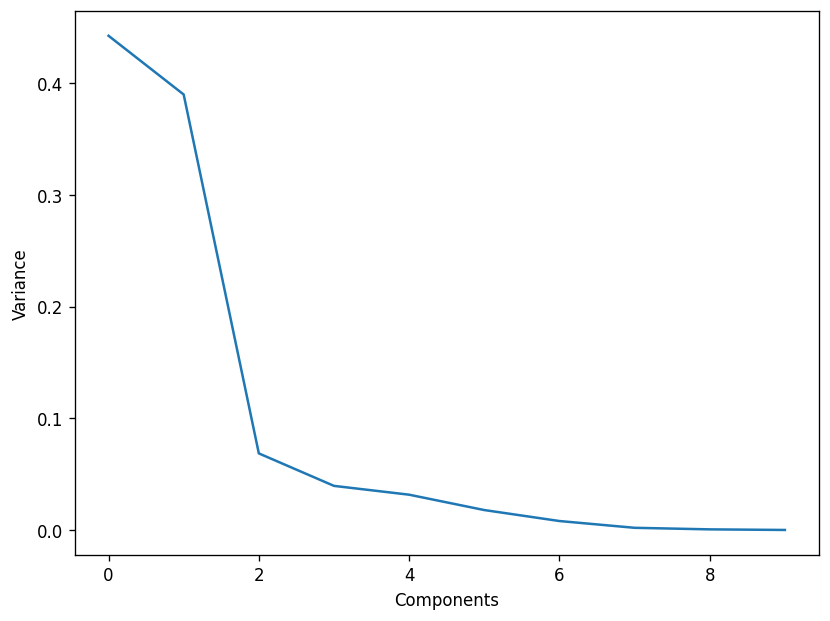

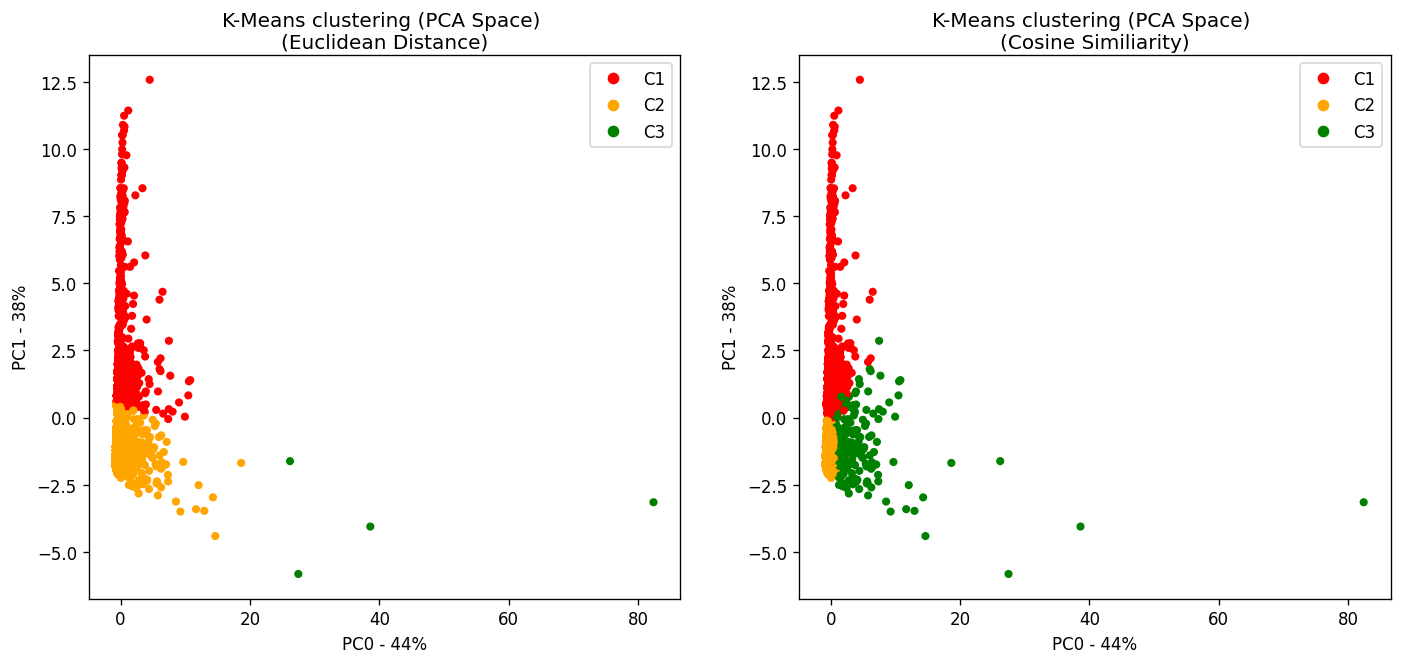

K-means with Euclidean Distance:


,C1,C2,C3
Number of Classes,1121,2375,4


K-means with Cosine Similarity:


,C1,C2,C3
Number of Classes,1284,1965,251


Standardized/Normalized books features matrix : 


,Nb rating,Average Rating,Bayes Rating,Median,STD,Depreciation,Neutral,Appreciations,MaxStarVotes,Class
0385663978,-0.084212,-0.490238,-0.547984,-0.494701,-0.118227,-0.064478,0.025305,-0.100468,-0.408163,0.109970
B007D8SV6W,-0.199163,-0.331716,-0.238569,-0.617564,-0.217924,-0.158988,-0.136312,-0.205370,-0.509534,0.137282
157965441X,-0.208986,0.331471,0.323677,0.589026,-0.178946,-0.106893,-0.292509,-0.201949,0.437840,0.182311
0307729249,0.383437,0.021408,0.034936,0.509636,0.345952,0.178092,0.325678,0.407077,0.378828,0.157739
080785493X,-0.267178,0.256856,0.191923,0.595013,-0.259528,-0.107980,-0.295483,-0.275505,0.442291,0.184164
...,...,...,...,...,...,...,...,...,...,...
B004H8H2PM,-0.267436,0.257105,0.192108,0.595589,-0.292629,-0.213488,-0.183039,-0.275771,0.442719,0.184342
1491215836,-0.097301,0.611262,0.637150,0.316234,-0.046830,-0.113354,-0.157041,-0.079921,0.235066,0.097878
0312366930,-0.157010,0.630866,0.509028,0.369027,-0.143470,-0.132277,-0.183258,-0.148695,0.274309,0.114218
B00GOKUTN8,-0.108862,0.540468,0.596640,0.417780,-0.069262,-0.149753,-0.128394,-0.093033,0.310548,0.129308


PC axis composition : 


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
Nb rating,0.035887,-0.007322,0.479314,-0.017447,-0.043409,-0.080817,0.028484,-0.106749,-0.375784,-7.789588e-01
Average Rating,-0.495630,0.476985,0.044507,0.118449,0.019883,0.307354,0.337295,-0.539584,0.105093,2.220446e-16
Bayes Rating,-0.496665,0.479311,0.077973,0.044451,0.019594,-0.151232,-0.201616,0.659018,-0.131607,-3.330669e-16
Median,-0.577817,-0.491416,0.000153,-0.643014,-0.079205,0.061111,-0.017181,-0.026255,-0.013394,5.551115e-17
STD,-0.008014,0.043114,0.522456,-0.066455,-0.021377,-0.356968,-0.132032,-0.065487,0.755710,2.775558e-17
Depreciation,0.079000,-0.124638,0.243222,-0.025044,0.100557,0.031926,0.858239,0.397980,0.039953,1.036863e-01
Neutral,0.104714,-0.067237,0.407208,0.045894,-0.109259,0.822855,-0.262190,0.205393,0.085046,9.694907e-02
Appreciations,0.015735,0.022493,0.505353,-0.025283,-0.055088,-0.239095,-0.067749,-0.236299,-0.499524,6.107971e-01
MaxStarVotes,-0.386166,-0.522013,0.069468,0.712615,0.241888,-0.055451,-0.063503,-0.005112,0.009437,-3.469447e-18
Class,-0.076629,-0.079276,-0.063676,0.233697,-0.952372,-0.081364,0.114475,0.041640,0.026518,-7.979728e-17


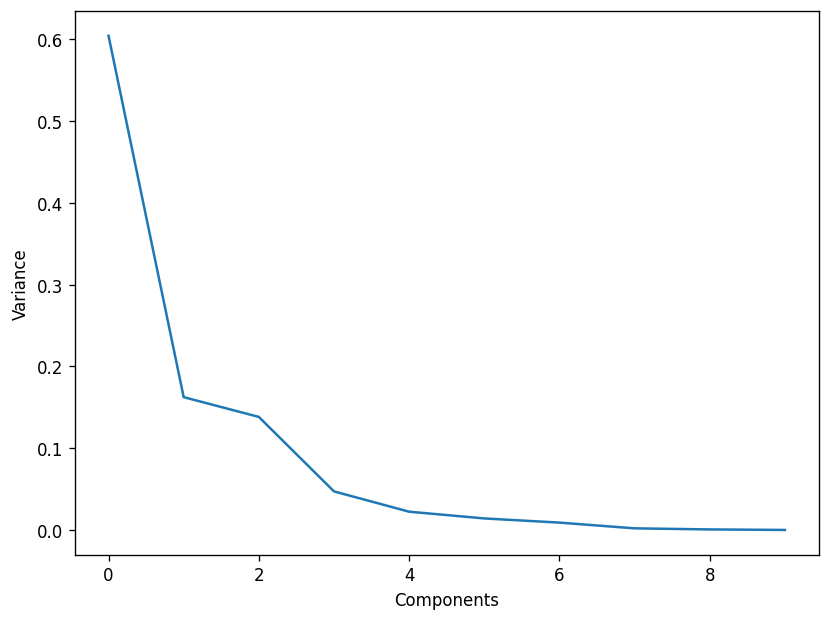

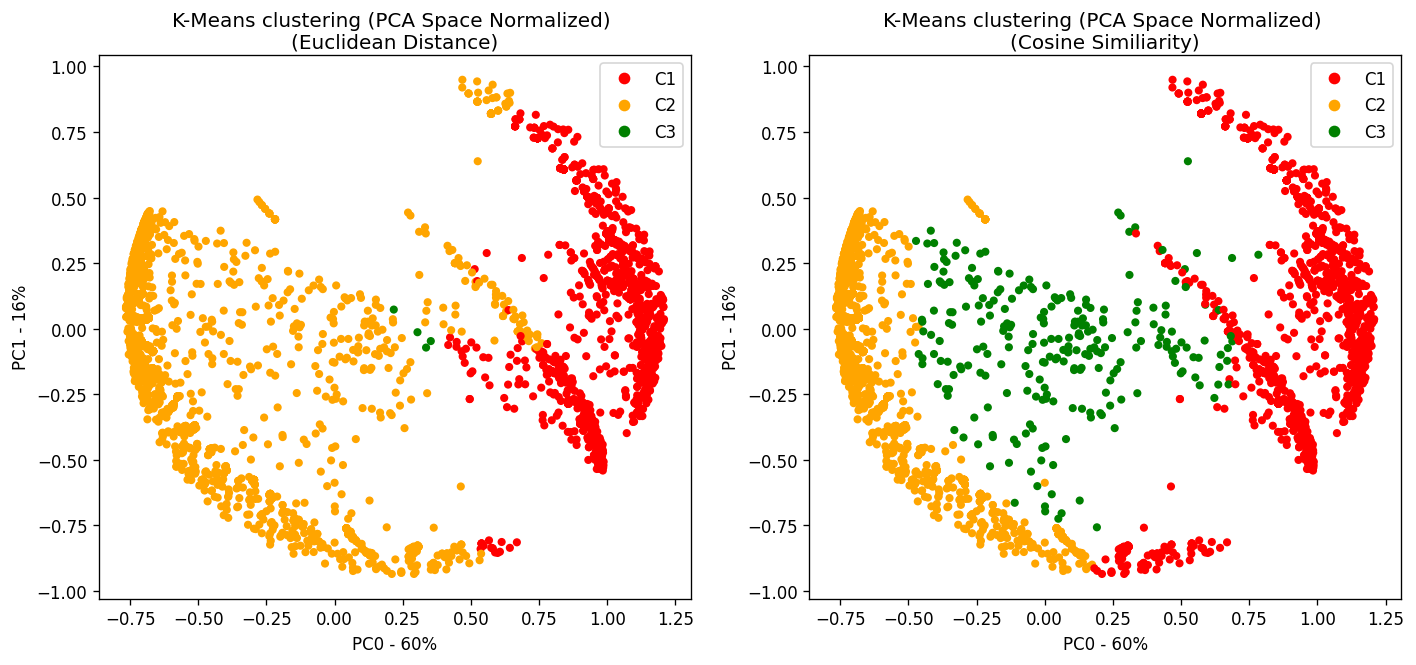

In [16]:
def scatterPlotHelper(plotData):
    fig, ax = plt.subplots(1, len(plotData), figsize=(14,6), dpi=120)
    for i in range(len(plotData)):
        if (plotData[i].axisLabels != []): ax[i].set(xlabel=plotData[i].axisLabels[0], ylabel=plotData[i].axisLabels[1])
        scatter = ax[i].scatter(x=plotData[i].dataXY[0], y=plotData[i].dataXY[1], c=plotData[i].dataLabels, cmap=colors, s=15)
        ax[i].legend(handles=scatter.legend_elements(num=3)[0], labels=CLASSES)
        ax[i].set_title(plotData[i].title, loc='center', wrap=True)
    plt.show()


def calculatePCA(booksData, normalize=False):
    # Data Standardization
    pdBooksFeaturesStandardized = (booksData - booksData.mean()) / booksData.std()
    if (normalize):
        pdBooksFeaturesNormalized = pd.DataFrame(
            data=preprocessing.normalize(pdBooksFeaturesStandardized), 
            columns=booksData.columns, 
            index=booksData.index
        )
    else:
        pdBooksFeaturesNormalized = pdBooksFeaturesStandardized
    # PCA Calculations
    pca = PCA(n_components=booksData.shape[1])
    pca.fit(pdBooksFeaturesNormalized)
    # PCA Results
    booksFeaturesPCA = pd.DataFrame(
        data=pca.components_.T,
        columns=[f"PC{i}" for i in range(len(booksData.columns))],
        index=booksData.columns
    )
    return pdBooksFeaturesNormalized, booksFeaturesPCA, pca

def displayPCAResults(pdBooksFeaturesStandNorm, booksFeaturesPCA, pca):
    # Display standardized data 
    print("Standardized/Normalized books features matrix : ")
    display(pdBooksFeaturesStandNorm)
    # Plot all PCA axis and their contributions
    print("PC axis composition : ")
    display(booksFeaturesPCA)
    # Plot PCA (2 major axis)
    plt.figure(figsize=(8, 6), dpi=120)
    plt.plot(pca.explained_variance_ratio_)
    plt.ylabel("Variance")
    plt.xlabel("Components")
    plt.show()

def displayKmeansClustering(booksData, normalizePca=False, displayPcaResults=False):
    kmeansEucliCoords, kmeansEucliLabels = kmeansClustering(booksData, "euclidean")
    kmeansCosCoords, kmeansCosLabels = kmeansClustering(booksData, "cosine")
    pdBooksFeaturesStandNorm, booksFeaturesPCA, pca = calculatePCA(booksData, normalizePca)
    if (displayPcaResults): displayPCAResults(pdBooksFeaturesStandNorm, booksFeaturesPCA, pca)
    pcaSpace = pca.transform(pdBooksFeaturesStandNorm)
    pcaSpaceXY = (pcaSpace[:,0], pcaSpace[:,1])
    pcaAxisLabels = [f"PC0 - {math.floor(pca.explained_variance_ratio_[0]*100)}%", f"PC1 - {math.floor(pca.explained_variance_ratio_[1]*100)}%"]
    kmeansEucli = PlotData(
        inputData=kmeansEucliCoords,
        dataXY=pcaSpaceXY,
        dataLabels=kmeansEucliLabels, 
        title=f"K-Means clustering (PCA Space{' Normalized' if normalizePca else ''}) \n(Euclidean Distance)",
        axisLabels=pcaAxisLabels
    )
    kmeansCos = PlotData(
        inputData=kmeansCosCoords,
        dataXY=pcaSpaceXY,
        dataLabels=kmeansCosLabels, 
        title=f"K-Means clustering (PCA Space{' Normalized' if normalizePca else ''}) \n(Cosine Similiarity)",
        axisLabels=pcaAxisLabels
    )
    scatterPlotHelper([kmeansEucli, kmeansCos])
    return kmeansEucli, kmeansCos

kmeansEucli, kmeansCos = displayKmeansClustering(pdBooksFeatures, normalizePca=False, displayPcaResults=True)
kmeansEucliNorm, kmeansCosNorm = displayKmeansClustering(pdBooksFeatures, normalizePca=True, displayPcaResults=True)

**Q3 : Interprétation des résultats visuelles**
TODO

Spectral clustering with Euclidean Distance : 


,C1,C2,C3
Number of Classes,3320,179,1


Spectral clustering with Cosine Similarity : 


,C1,C2,C3
Number of Classes,1686,1287,527


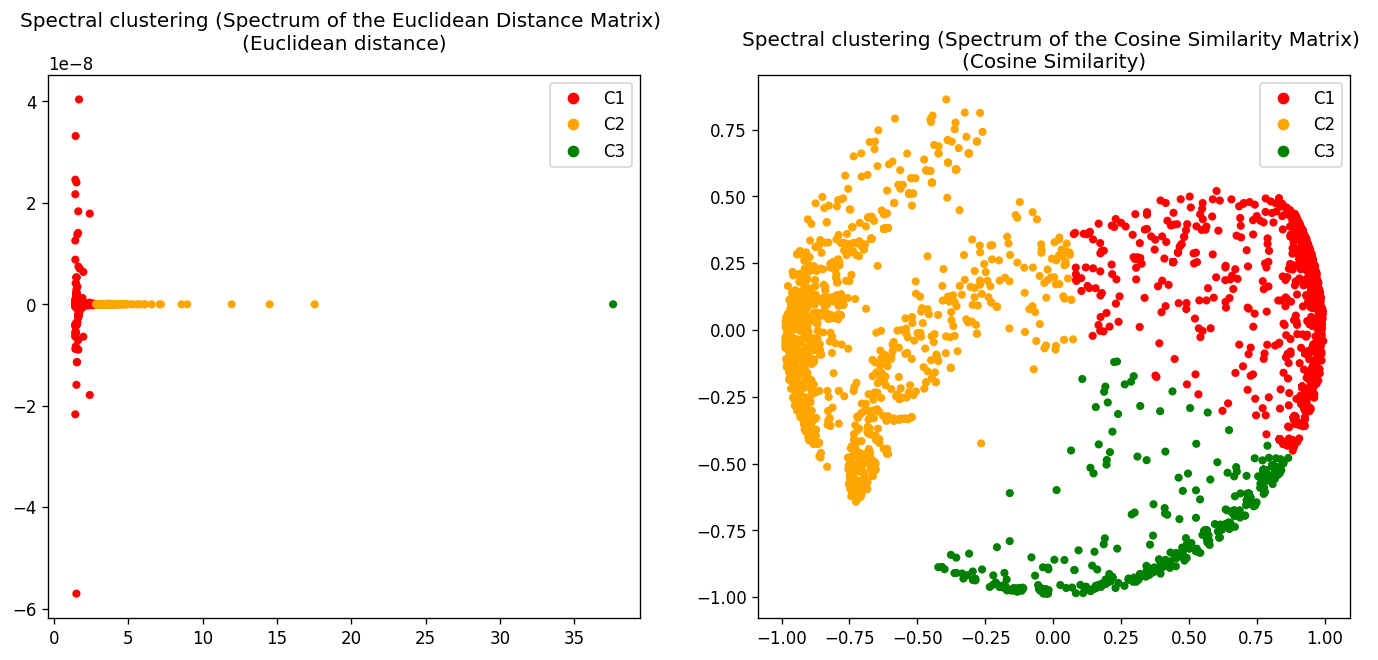

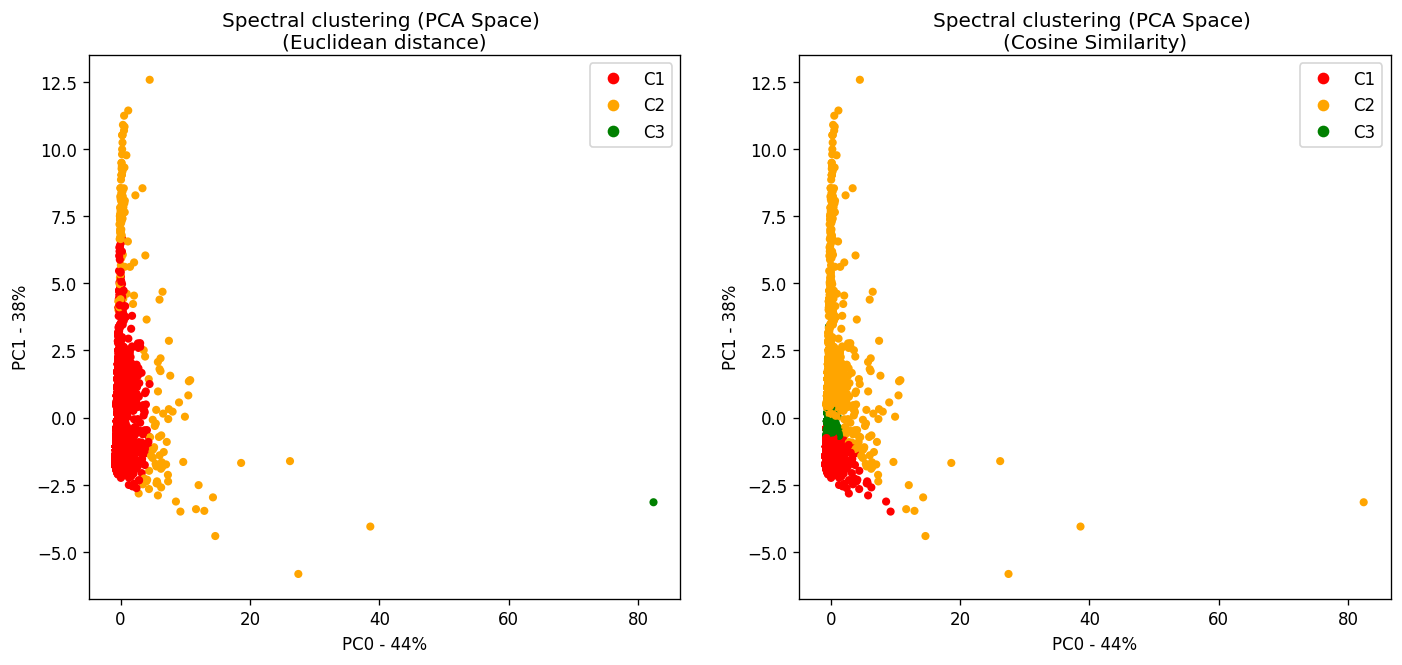

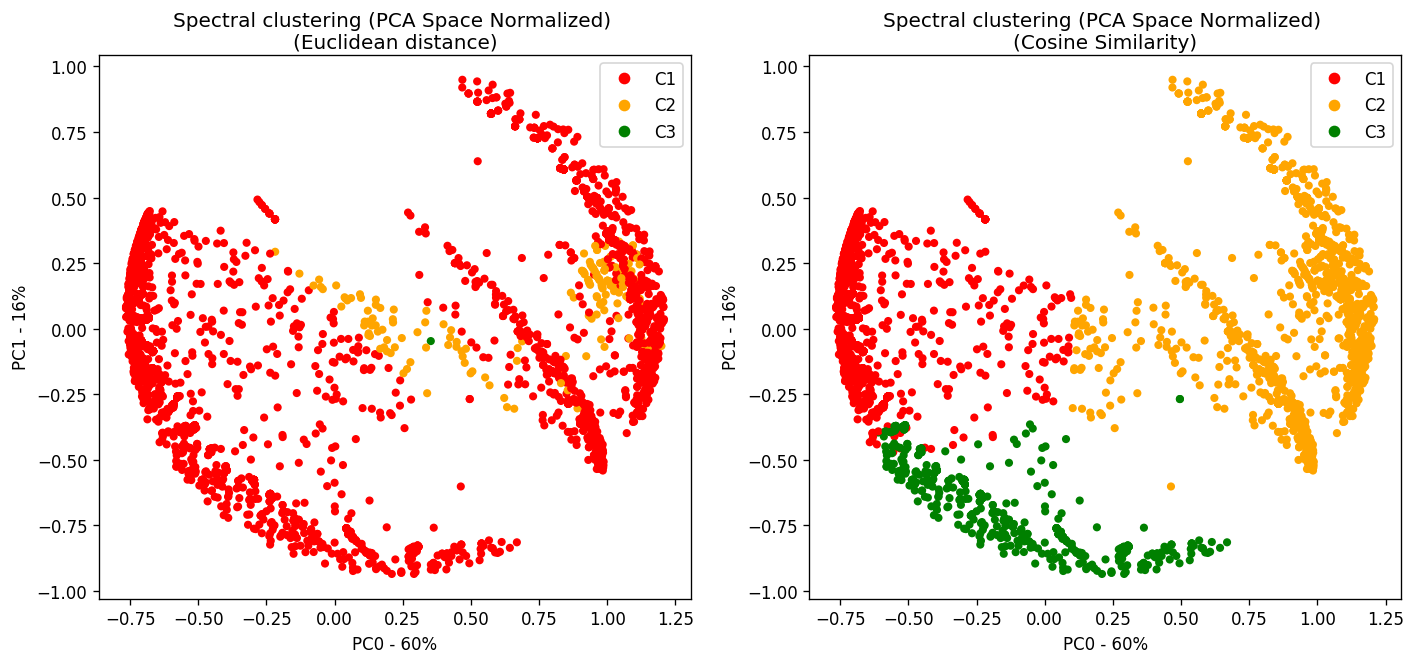

In [17]:
# Q4
def spectralClustering(booksData, distFunc):
    # Standardize data before doing kmeans :
    data = (booksData - booksData.mean()) / booksData.std()
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html
    M = sp.spatial.distance.squareform(sp.spatial.distance.pdist(np.asarray(data), distFunc))
    if (distFunc == "cosine"): M = 1 - M # SciPy uses distance cos which is equal to 1 - sim cos
    eigenValues, eigenVectors = np.linalg.eig(M)
    idx =  eigenValues.argsort()[::-1]
    eigenValues = eigenValues[idx].real
    eigenVectors = eigenVectors[:,idx].real
    positiveCount = eigenValues[eigenValues > 0].size
    P = np.stack(eigenVectors[:,0:positiveCount])
    D = np.diag(eigenValues[0:positiveCount])
    spectralDataMat = P @ np.sqrt(D)
    kmeans = KMeans(n_clusters=NB_CLUSTERS, random_state=0, max_iter=1000).fit(spectralDataMat[:,0:2])
    return spectralDataMat[:,0:2], kmeans.labels_

def displaySpectralClustering(booksData, kmeansEucli, kmeansCos, kmeansEucliNorm, kmeansCosNorm):
    eucliCoords, spectralEucliLabels = spectralClustering(booksData, "euclidean")
    cosCoords, spectralCosLabels =  spectralClustering(booksData, "cosine")
    print("Spectral clustering with Euclidean Distance : ")
    display(pd.DataFrame(
        data=np.array([[np.count_nonzero(spectralEucliLabels == i) for i in range(0, NB_CLUSTERS)]]),
        index=["Number of Classes"],
        columns=CLASSES
    ))
    print("Spectral clustering with Cosine Similarity : ")
    display(pd.DataFrame(
        data=np.array([[np.count_nonzero(spectralCosLabels == i) for i in range(0, NB_CLUSTERS)]]),
        index=["Number of Classes"],
        columns=CLASSES
    ))
    spectralEucli = PlotData(
        inputData=eucliCoords,
        dataXY=(eucliCoords[:,0],eucliCoords[:,1]), 
        dataLabels=spectralEucliLabels, 
        title="Spectral clustering (Spectrum of the Euclidean Distance Matrix) \n(Euclidean distance)"
    )
    spectralCos = PlotData(
        inputData=cosCoords,
        dataXY=(cosCoords[:,0],cosCoords[:,1]), 
        dataLabels=spectralCosLabels, 
        title="Spectral clustering (Spectrum of the Cosine Similarity Matrix) \n(Cosine Similarity)"
    )
    scatterPlotHelper([spectralEucli, spectralCos])
    spectralEucliPCASpace = PlotData(
        inputData=eucliCoords,
        dataXY=kmeansEucli.dataXY, 
        dataLabels=spectralEucliLabels, 
        title="Spectral clustering (PCA Space) \n(Euclidean distance)",
        axisLabels=kmeansEucli.axisLabels
    )
    spectralCosPCASpace = PlotData(
        inputData=cosCoords,
        dataXY=kmeansCos.dataXY, 
        dataLabels=spectralCosLabels, 
        title="Spectral clustering (PCA Space) \n(Cosine Similarity)",
        axisLabels=kmeansCos.axisLabels
    )
    scatterPlotHelper([spectralEucliPCASpace, spectralCosPCASpace])
    spectralEucliPCASpaceNorm = PlotData(
        inputData=eucliCoords,
        dataXY=kmeansEucliNorm.dataXY, 
        dataLabels=spectralEucliLabels, 
        title="Spectral clustering (PCA Space Normalized) \n(Euclidean distance)",
        axisLabels=kmeansEucliNorm.axisLabels
    )
    spectralCosPCASpaceNorm = PlotData(
        inputData=cosCoords,
        dataXY=kmeansCosNorm.dataXY, 
        dataLabels=spectralCosLabels, 
        title="Spectral clustering (PCA Space Normalized) \n(Cosine Similarity)",
        axisLabels=kmeansCosNorm.axisLabels
    )
    scatterPlotHelper([spectralEucliPCASpaceNorm, spectralCosPCASpaceNorm])
    return spectralEucli, spectralCos, spectralEucliPCASpace, spectralCosPCASpace, spectralEucliPCASpaceNorm, spectralCosPCASpaceNorm

spectralEucli, spectralCos, spectralEucliPCASpace, spectralCosPCASpace, spectralEucliPCASpaceNorm, spectralCosPCASpaceNorm = displaySpectralClustering(
    pdBooksFeatures[CRITERIAS], 
    kmeansEucli,
    kmeansCos,
    kmeansEucliNorm,
    kmeansCosNorm
)

In [18]:
# Q5
def getAccuracyMatrix(pdBooksFeatures, kmeansEucli, kmeansCos, spectralEucli, spectralCos):
    bookClasses = pdBooksFeatures[["Class"]].to_numpy(dtype=int).T[0]
    perfMetric = np.array([
        [
            sk.metrics.silhouette_score(kmeansEucli.inputData, kmeansEucli.dataLabels, metric='euclidean'), 
            sk.metrics.adjusted_mutual_info_score(kmeansEucli.dataLabels, bookClasses), 
            sk.metrics.silhouette_score(kmeansCos.inputData, kmeansCos.dataLabels, metric="cosine"), 
            sk.metrics.adjusted_mutual_info_score(kmeansCos.dataLabels, bookClasses), 
        ],
        [
            sk.metrics.silhouette_score(spectralEucli.inputData, spectralEucli.dataLabels, metric='euclidean'), 
            sk.metrics.adjusted_mutual_info_score(spectralEucli.dataLabels, bookClasses), 
            sk.metrics.silhouette_score(spectralCos.inputData, spectralCos.dataLabels, metric="cosine"), 
            sk.metrics.adjusted_mutual_info_score(spectralCos.dataLabels, bookClasses), 
        ],
    ])
    return perfMetric

def displayAccuracyMatrix(pdBooksFeatures, kmeansClustering, spectraClustering):
    accMat = getAccuracyMatrix(
        pdBooksFeatures, 
        kmeansClustering[0], 
        kmeansClustering[1], 
        spectraClustering[0], 
        spectraClustering[1]
    )
    display(pd.DataFrame(
        data=accMat, 
        columns=["Silhouet (Euclidean)", "Mut. Info. (Euclidean)", "Silhouet (Cosine)", "Mut. Info. (Cosine)",],
        index=["K-means", "Spectral"]
    ))
    return accMat

_ = displayAccuracyMatrix(
    pdBooksFeatures,
    (kmeansEucli, kmeansCos), 
    (spectralEucli, spectralCos), 
)

,Silhouet (Euclidean),Mut. Info. (Euclidean),Silhouet (Cosine),Mut. Info. (Cosine)
K-means,0.460333,0.120177,0.660006,0.081247
Spectral,0.863087,0.303136,0.802339,0.068890


**b-1) Selon vous quel serait le risque de prendre aléatoirement un sous-ensemble de données pour effectuer les tâches a-1) à a-5) ?**

-> Puisque les 3 catégories ne sont pas distrbué d'une maniere uniforme si on prend aléatoirement un sous ensemble de données, on risque d'avoir des catégories qui seront forcément sous représenter voir même pas présent. Par conséquence, notre clustering sera forcément faux car on risque d'appliquer l'algorithme de clustering sur un ensemble de données qui appartient au même groupe (qui n'as pas de sens).

,1 ⭐,2 ⭐,3 ⭐,4 ⭐,5 ⭐,Depreciation,Neutral,Appreciations,MaxStarVotes,Class
042518269X,3,1,0,1,1,4,0,2,0,0
0765320789,3,1,4,2,2,4,4,4,2,0
0865478546,1,3,1,2,1,4,1,3,1,0
1590590961,4,4,3,1,6,8,3,7,4,0
1888846445,0,2,1,1,1,2,1,2,1,0
...,...,...,...,...,...,...,...,...,...,...
0785116826,0,0,1,3,2,0,1,5,3,2
1607744465,2,1,3,4,6,3,3,10,4,2
1583820620,0,1,0,1,3,1,0,4,4,2
0142400203,1,0,0,1,4,1,0,5,4,2


,Nb rating,Average Rating,Bayes Rating,Median,STD,Depreciation,Neutral,Appreciations,MaxStarVotes,Class
042518269X,6.0,2.333333,2.848085,2.0,0.979796,4.0,0.0,2.0,0.0,0.0
0765320789,12.0,2.916667,3.078173,3.0,1.019804,4.0,4.0,4.0,2.0,0.0
0865478546,8.0,2.875000,3.102226,3.0,0.800000,4.0,1.0,3.0,1.0,0.0
1590590961,18.0,3.055556,3.144736,3.0,1.624808,8.0,3.0,7.0,4.0,0.0
1888846445,5.0,3.200000,3.332893,3.0,0.632456,2.0,1.0,2.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
0785116826,6.0,4.166667,3.848085,4.0,1.166190,0.0,1.0,5.0,3.0,2.0
1607744465,16.0,3.687500,3.634711,4.0,1.720465,3.0,3.0,10.0,4.0,2.0
1583820620,5.0,4.200000,3.832893,5.0,1.095445,1.0,0.0,4.0,4.0,2.0
0142400203,6.0,4.166667,3.848085,5.0,1.469694,1.0,0.0,5.0,4.0,2.0


Different classes count : 


,Count,%
⭐,3500,33
⭐⭐,3500,33
⭐⭐⭐,3500,33


K-means with Euclidean Distance:


,C1,C2,C3
Number of Classes,3558,6848,94


K-means with Cosine Similarity:


,C1,C2,C3
Number of Classes,3774,6217,509


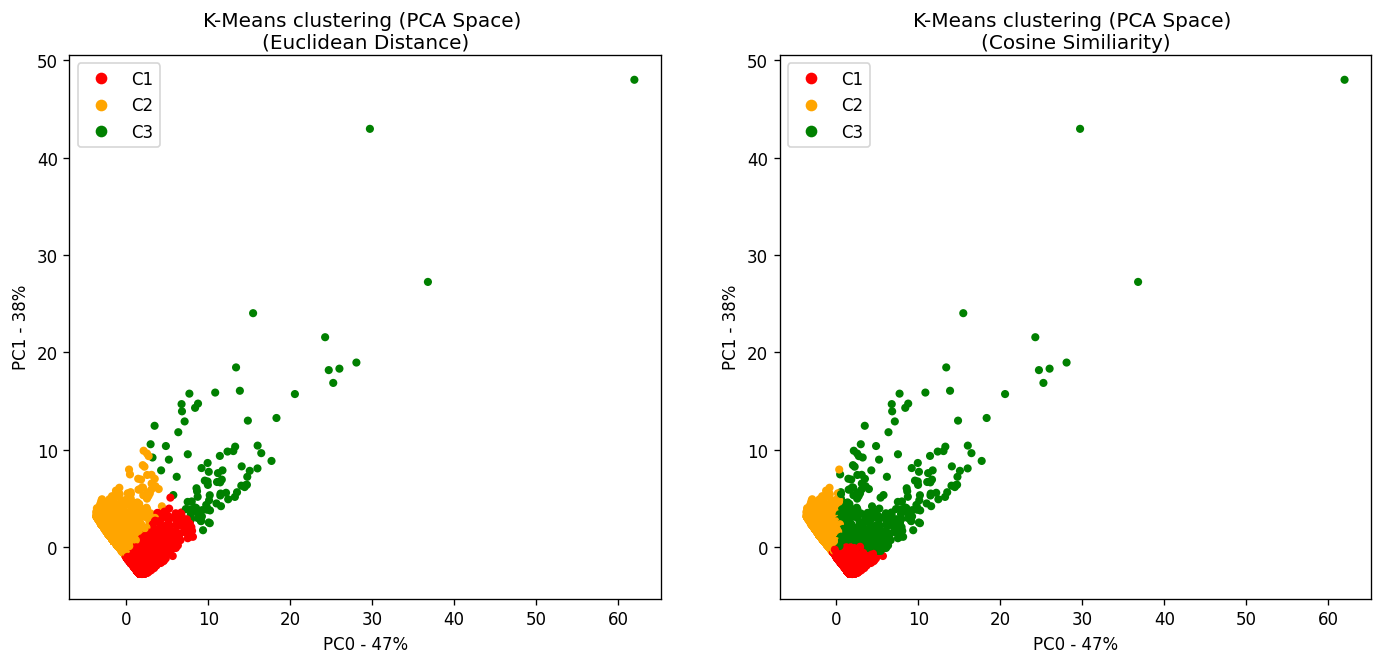

K-means with Euclidean Distance:


,C1,C2,C3
Number of Classes,3558,6848,94


K-means with Cosine Similarity:


,C1,C2,C3
Number of Classes,3774,6217,509


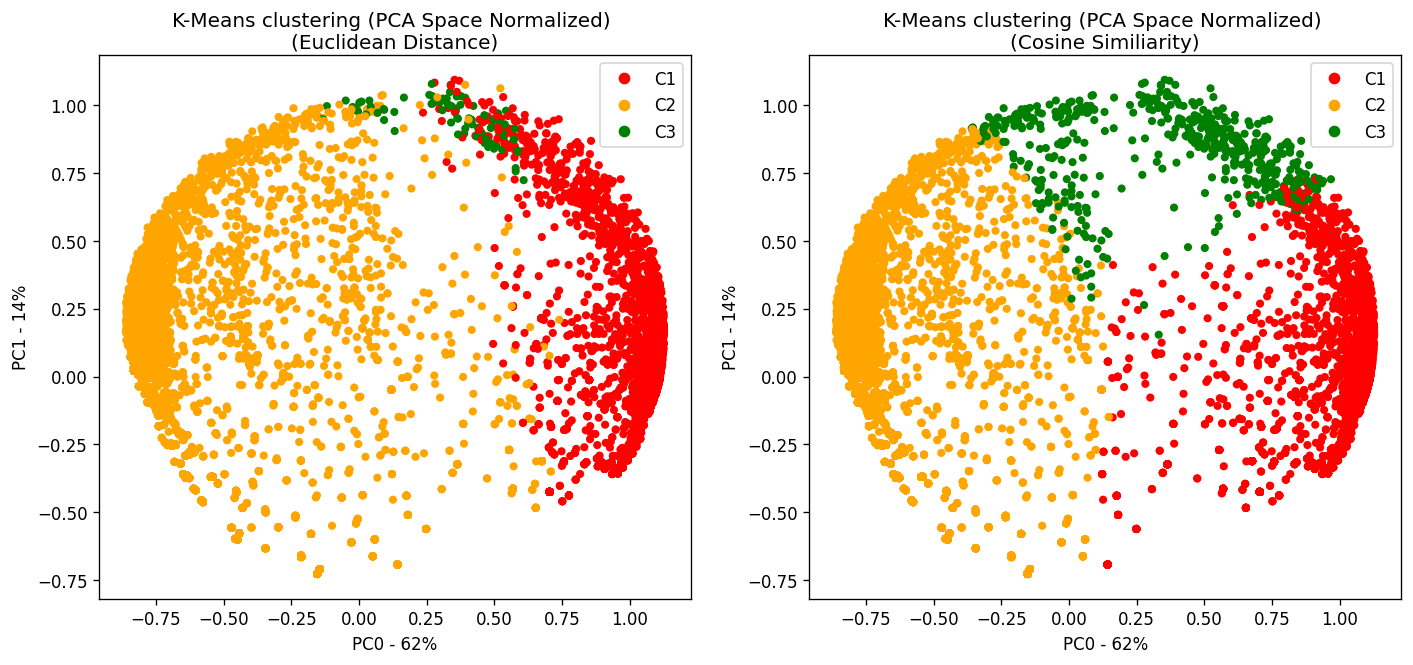

Spectral clustering with Euclidean Distance : 


,C1,C2,C3
Number of Classes,10370,121,9


Spectral clustering with Cosine Similarity : 


,C1,C2,C3
Number of Classes,4443,3890,2167


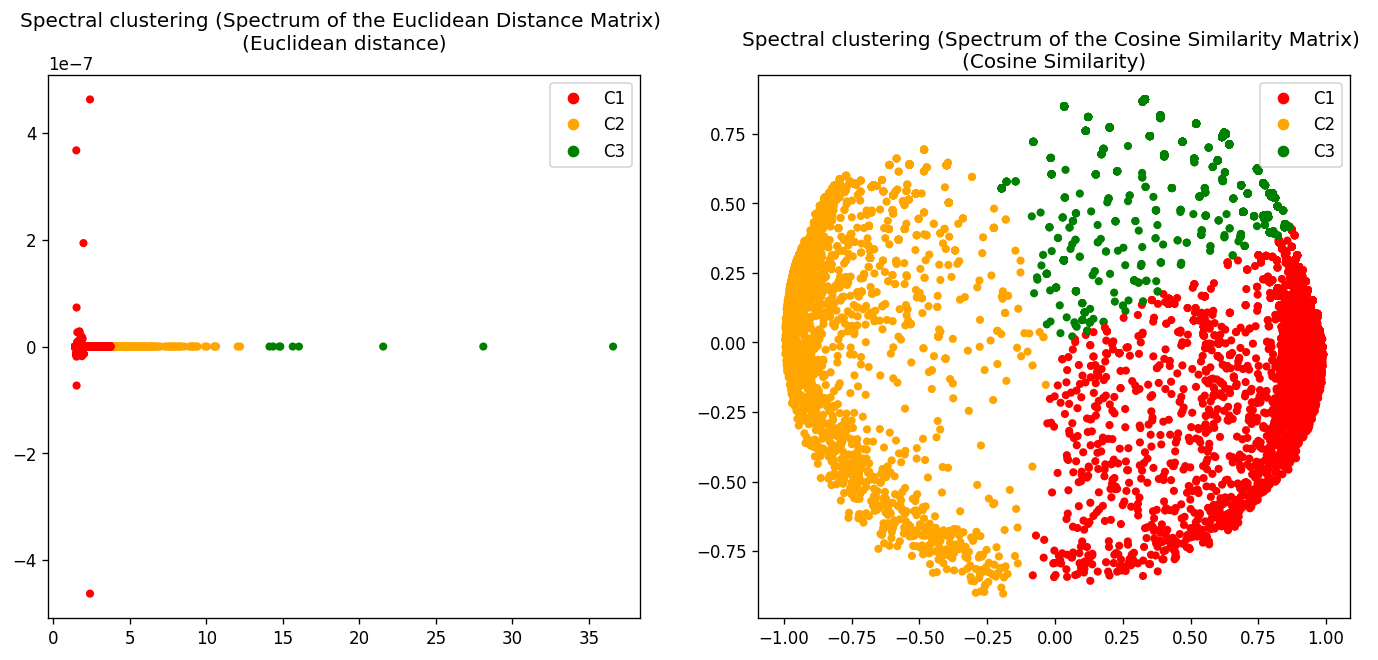

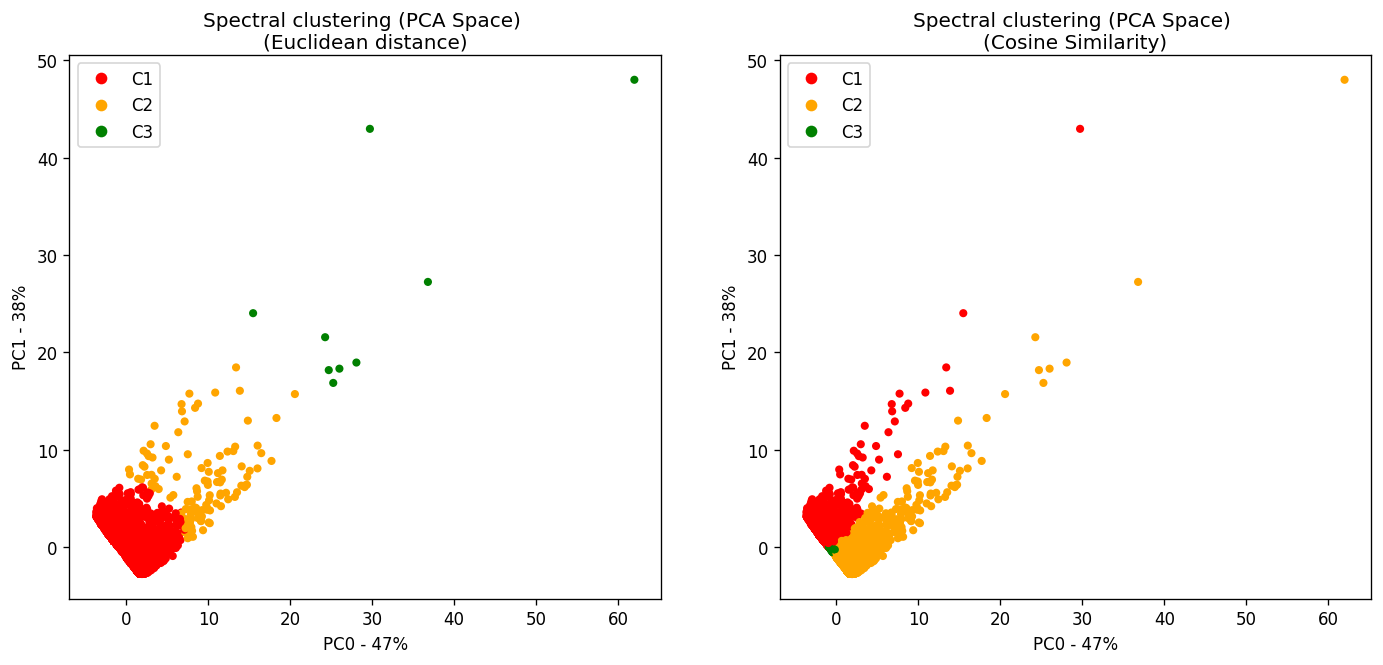

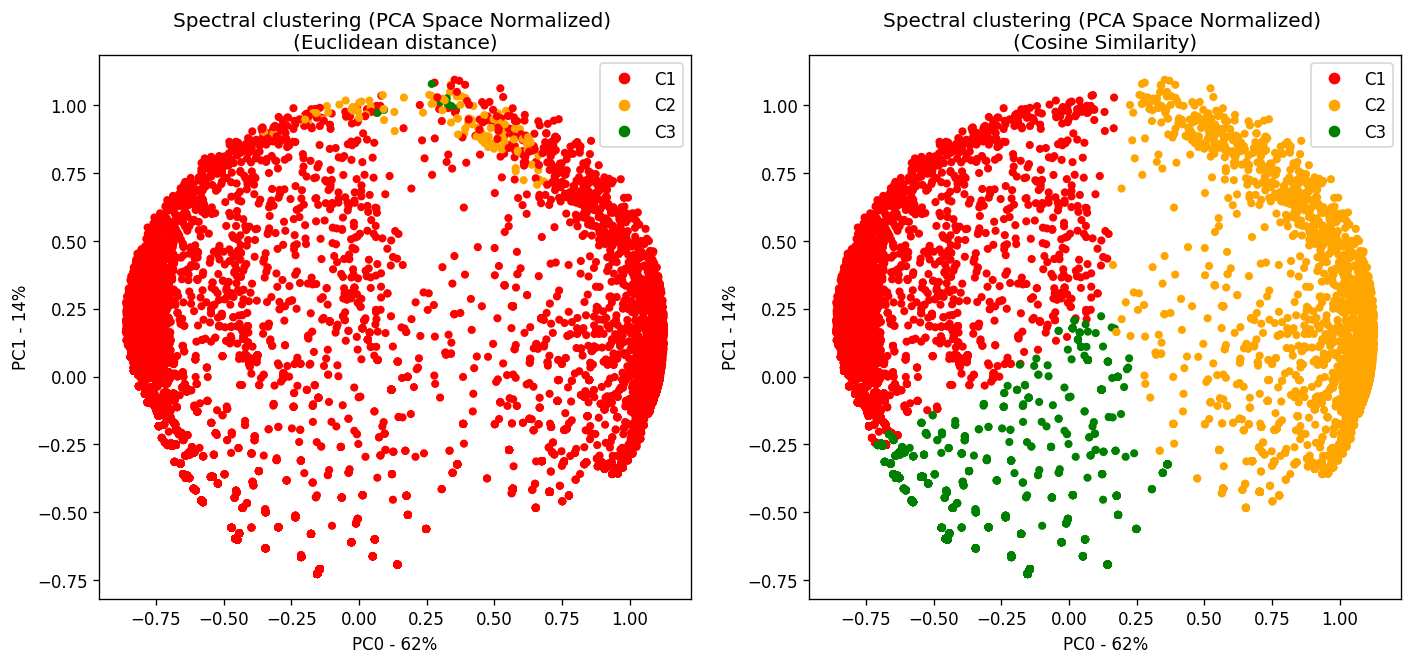

,Silhouet (Euclidean),Mut. Info. (Euclidean),Silhouet (Cosine),Mut. Info. (Cosine)
K-means,0.491088,0.529793,0.638287,0.455737
Spectral,0.912962,0.011054,0.765644,0.558473


In [19]:
# Q B-3
def fullAnalysis(pdBooksFeatures):
    kmeansEucli, kmeansCos = displayKmeansClustering(pdBooksFeatures[CRITERIAS])
    kmeansEucliNorm, kmeansCosNorm = displayKmeansClustering(pdBooksFeatures[CRITERIAS], normalizePca=True)
    spectralEucli, spectralCos, _, _, _, _ = displaySpectralClustering(
        pdBooksFeatures[CRITERIAS], 
        kmeansEucli,
        kmeansCos,
        kmeansEucliNorm,
        kmeansCosNorm
    )
    displayAccuracyMatrix(
        pdBooksFeatures, 
        (kmeansEucli, kmeansCos), 
        (spectralEucli, spectralCos)
    )

#classesCount = [ (pdBooks.Class.values == i).sum() for i in range(0, 3) ]
# nbSamples = np.min(classesCount)
nbSamples = BOOKS_SAMPLING_NB
pdBooksSampled = pdBooks.groupby('Class', group_keys=False).apply(lambda x: x.sample(nbSamples))
display(pdBooksSampled)

pdSampledBooksFeatures = getBookStats(pdBooksSampled)
display(pdSampledBooksFeatures)
displayDifferentClassesCount(pdSampledBooksFeatures)

fullAnalysis(pdSampledBooksFeatures)